In [1]:
import numpy as np       # for scientific computation
import pandas as pd      # for data - preprocessing

import matplotlib.pyplot as plt   # for basic visualization
import seaborn as sns             # for advanced visualization

from sklearn.model_selection import train_test_split      # for splitting data into training and testing part
from sklearn.preprocessing import LabelEncoder            # for pre-processing textual data

# Keras API for building up a Neural network.
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
#loading the dataset
data = pd.read_csv('train.csv')
data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


Since, for detecting fake news content can either be in title or in text. Hence, it is a good approach to combine them both to get precise results.

In [3]:
data['News'] = data['title'] + data['text']
data_final = data[['News','label']]

In [4]:
#dropping the null values as they impart no significance.
data_final.dropna(inplace=True)

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


We can use countplot to count the total number of fake and real news. Hence,  we can say that fake and real news are equally present and data is uniform.

Here, 1 denotes fake news and 0 denotes real news.

Text(0.5, 1.0, 'Fake vs Real News')

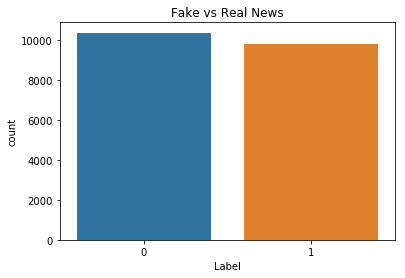

In [5]:
sns.countplot(data_final.label)
plt.xlabel('Label')
plt.title('Fake vs Real News')

In [6]:
X = data_final.News
Y = data_final.label
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

Next, we store <b>News</b> data into X column and <b>labels </b> whether news is real or fake into Y variable.
Then we apply labelEncoder which is used to convert categorical data, or text data, into numbers, which our predictive models can better understand.

In [7]:
#we split our dataset into 85% training and 15% testing
X_train, X_test, Y_train, Y_test= train_test_split(X, Y , test_size=0.15)

We then tokenize our words using  keras library and then converting them into numbers. This all is a part of text - processing and we can also use spacy or nltk to achieve this.

This function transforms a list of num_samples sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps). num_timesteps is either the maxlen argument if provided, or the length of the longest sequence otherwise.

You can refer to this link for further information.<br>
https://keras.io/preprocessing/sequence/

In [8]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words = max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences, 
                                           maxlen=max_len)

In [9]:
print(sequences[0])

[499, 278, 253, 582, 278, 6, 499, 28, 1, 582, 3, 736, 641, 5, 229, 2, 924, 306, 47, 7, 178, 47, 25, 815, 10, 1, 11, 202, 44, 26, 3, 116, 1, 165, 2, 278, 249, 38, 76, 5, 209, 26, 212, 47, 554, 209, 495, 58, 1, 278, 156, 74, 2, 483, 98, 495, 99, 25, 9, 5, 278, 2, 785, 2, 982, 737, 11, 573, 41, 459, 599, 145, 31, 25, 1, 41, 12, 5, 4, 114, 5, 826, 165, 2, 278, 188, 165, 2, 1, 605, 1, 278, 28, 7, 1, 14, 91, 641, 229, 2, 72, 924, 4, 577, 72, 75, 256, 1, 2, 52, 573, 8, 25, 5, 3, 1, 49, 952, 156, 914, 138, 140, 232, 63, 13, 32, 728, 32, 140, 232, 619, 30, 32, 140, 137, 99, 2, 647, 795, 7, 11, 703, 16, 465, 164, 79, 2, 21, 20, 278, 86, 51, 31, 209, 471, 868, 31, 51, 75, 4, 97, 465, 164, 600, 554, 11, 382, 10, 198]


In [10]:
print(sequences_matrix)

[[  7 178  47 ... 382  10 198]
 [  0   0   0 ...  11  36  17]
 [153 609   3 ... 119  25 153]
 ...
 [  5 192   9 ... 174 347 172]
 [ 62   1  11 ...  10 198 382]
 [ 28  48  61 ... 998 604  34]]


Nextly, we built a function called <strong>fake_news_detector</strong> to call a LSTM model which will help in classifying fake news using syntax and sequences of the news article.

In [11]:
def fake_news_detector():
    inputs = Input(name='inputs', shape = [max_len])
    layer = Embedding(max_words, 50, input_length = max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256, name = 'FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1, name = 'out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

We then call our function and we print the summary and we use RMSprop() as optimiser, metrics for getting accuracy and binary crossentropy to find the loss. Since, we are only dealing with two values either 1 or 0 hence, we used binary_crossentropy

In [12]:
model = fake_news_detector()
model.summary()
model.compile(loss='binary_crossentropy', 
              optimizer = RMSprop(), 
              metrics = ['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

Fitting our model using features stored in sequence_matrix containing matrix of numbers for each sentence and Y_train storing labels. We used batch size of 128 (Number of samples processed before the model is updated).<br>
We have used 10 epochs for training purposes to get better accuracy.

In [13]:
model.fit(sequences_matrix, Y_train, batch_size=128, epochs=10,
         validation_split=0.2,
          callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])

/srv/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 13737 samples, validate on 3435 samples
Epoch 1/10
13737/13737 [==============================] - 96s 7ms/step - loss: 0.3835 - accuracy: 0.8278 - val_loss: 0.2528 - val_accuracy: 0.9025
Epoch 2/10
13737/13737 [==============================] - 93s 7ms/step - loss: 0.2206 - accuracy: 0.9158 - val_loss: 0.2595 - val_accuracy: 0.8876


For testing purpose we convert the testing data into sequence using same technique used for training data.

In [14]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen = max_len)

We find the model accuracy using evaluate function over testing data and then uses the parameters stored inside accuracy variable to get loss and final accuracy of model over testing data.

In [15]:
accuracy = model.evaluate(test_sequences_matrix, Y_test)

3031/3031 [==============================] - 6s 2ms/step


In [16]:
print("Test set \n Loss : {:0.3f} \n Accuracy: {:0.3f}".format(accuracy[0], accuracy[1]))

Test set 
 Loss : 0.248 
 Accuracy: 0.898
